<a href="https://colab.research.google.com/github/fajaralfad/klasifikasi-makanan-minangkabau-mobilenetV3/blob/main/Model_Klasifikasi_Makanan_Minangkabau_MobileNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Carching data kaggle dan Splitting data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub
import shutil

# Unduh dataset dari Kaggle
path = kagglehub.dataset_download("faldoae/padangfood")

print("Dataset berhasil diunduh di:", path)

# (Opsional) Pindahkan ke Google Drive
destination = "/content/drive/MyDrive/KlasifikasiMakananMinangkabau"

shutil.copytree(path, destination, dirs_exist_ok=True)
print("Dataset telah disalin ke:", destination)


100%|██████████| 114M/114M [00:00<00:00, 154MB/s]

Extracting files...


Dataset berhasil diunduh di: /root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1
Dataset telah disalin ke: /content/drive/MyDrive/KlasifikasiMakananMinangkabau


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
dataset_dir = "/content/drive/MyDrive/KlasifikasiMakananMinangkabau/dataset_padang_food"
base_dir = "/content/drive/MyDrive/KlasifikasiMakananMinangkabau/dataset_padang_food_Split"

In [ ]:
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

In [ ]:
# Ambil semua nama kelas (folder)
classes = os.listdir(dataset_dir)

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    if not os.path.isdir(cls_path):
        continue  # skip file non-folder

    imgs = os.listdir(cls_path)

    # Split 70% train, 15% val, 15% test
    train_files, temp_files = train_test_split(imgs, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Copy ke folder tujuan
    for split, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_dir = os.path.join(base_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for f in files:
            shutil.copy(os.path.join(cls_path, f), os.path.join(split_dir, f))

print("Dataset berhasil di-split menjadi train, val, dan test.")


Dataset berhasil di-split menjadi train, val, dan test.


In [ ]:
for split in ['train', 'val', 'test']:
    path = os.path.join(base_dir, split)
    total_images = sum([len(files) for _, _, files in os.walk(path)])
    print(f"{split}: {total_images} gambar")

train: 691 gambar
val: 149 gambar
test: 153 gambar


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from datetime import datetime
import json

# Dataset Configuration
IMG_SIZE = 224  # MobileNetV3 standard input
BATCH_SIZE = 16  # Small batch untuk dataset kecil
NUM_CLASSES = 9  # 9 makanan minangkabau

# Training Configuration
EPOCHS_PHASE1 = 15  # Training classification head
EPOCHS_PHASE2 = 30  # Fine-tuning
LEARNING_RATE_PHASE1 = 1e-3
LEARNING_RATE_PHASE2 = 1e-5

# Paths
DATASET_PATH = '/content/drive/MyDrive/KlasifikasiMakananMinangkabau/dataset_padang_food_Split'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Output
OUTPUT_DIR = f'output_mobilenetv3_small_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*60)
print("MobileNetV3 Small - Klasifikasi Makanan Minangkabau")
print("="*60)
print(f"Dataset: 691 train | 149 val | 153 test")
print(f"Classes: {NUM_CLASSES}")
print(f"Output: {OUTPUT_DIR}")
print("="*60)

MobileNetV3 Small - Klasifikasi Makanan Minangkabau
Dataset: 691 train | 149 val | 153 test
Classes: 9
Output: output_mobilenetv3_small_20251103_111044


In [ ]:
print("\n[1/7] Loading Dataset...")

# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Hanya rescaling untuk validation dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Load validation data
validation_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(f"\nKelas Makanan Minangkabau:")
for i, name in enumerate(class_names):
    print(f"  {i}. {name}")

# Simpan class names untuk Flutter
class_mapping = {i: name for i, name in enumerate(class_names)}
with open(os.path.join(OUTPUT_DIR, 'class_labels.json'), 'w') as f:
    json.dump(class_mapping, f, indent=2)

print(f"\nTotal training batches: {len(train_generator)}")
print(f"Total validation batches: {len(validation_generator)}")
print(f"Total test batches: {len(test_generator)}")


[1/7] Loading Dataset...
Found 691 images belonging to 9 classes.
Found 149 images belonging to 9 classes.
Found 153 images belonging to 9 classes.

Kelas Makanan Minangkabau:
  0. ayam_goreng
  1. ayam_pop
  2. daging_rendang
  3. dendeng_batokok
  4. gulai_ikan
  5. gulai_tambusu
  6. gulai_tunjang
  7. telur_balado
  8. telur_dadar

Total training batches: 44
Total validation batches: 10
Total test batches: 10


In [ ]:
print("\n[2/7] Building MobileNetV3-Small Model...")

def build_mobilenetv3_small(num_classes, img_size=224):

    # Load pre-trained MobileNetV3-Small
    base_model = MobileNetV3Small(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet',
        minimalistic=False,  # False = lebih akurat, True = lebih cepat
        include_preprocessing=False
    )

    # Freeze base model
    base_model.trainable = False

    # Build model
    inputs = keras.Input(shape=(img_size, img_size, 3), name='input_image')

    # Preprocessing untuk MobileNetV3
    x = keras.applications.mobilenet_v3.preprocess_input(inputs)

    # Base model
    x = base_model(x, training=False)

    # Classification head (optimized untuk mobile)
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization(name='bn')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)

    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs, outputs, name='MobileNetV3Small_Minangkabau')

    return model, base_model


[2/7] Building MobileNetV3-Small Model...


In [ ]:
model, base_model = build_mobilenetv3_small(NUM_CLASSES, IMG_SIZE)

# Model summary
print("\nModel Architecture:")
model.summary()

# Calculate model size
def get_model_size(model):
    """Estimate model size in MB"""
    param_size = sum([keras.backend.count_params(w) for w in model.trainable_weights])
    return param_size * 4 / (1024 ** 2)  # 4 bytes per parameter

print(f"\nEstimated model size: {get_model_size(model):.2f} MB")

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Architecture:


Model: "MobileNetV3Small_Minangkabau"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn (BatchNormalization)         │ (None, 576)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,473 (4.17 MB)

 Trainable params: 151,689 (592.54 KB)

 Non-trainable params: 940,784 (3.59 MB)


Estimated model size: 0.58 MB


In [ ]:
print("\n[3/7] Setting up Callbacks...")

# Create checkpoint directory
checkpoint_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

def get_callbacks(phase_name):
    """Get callbacks for training"""
    return [
        # Save best model
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, f'{phase_name}_best_model.h5'),
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),

        # Early stopping
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),

        # Reduce learning rate
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-7,
            verbose=1
        ),

        # CSV Logger
        keras.callbacks.CSVLogger(
            os.path.join(OUTPUT_DIR, f'{phase_name}_training.log')
        )
    ]


[3/7] Setting up Callbacks...


In [ ]:
print("\n[4/7] Phase 1: Training Classification Head...")
print(f"Epochs: {EPOCHS_PHASE1} | Learning Rate: {LEARNING_RATE_PHASE1}")

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

# Train
history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=get_callbacks('phase1'),
    verbose=1
)

print("\nPhase 1 Complete!")
print(f"Best Val Accuracy: {max(history_phase1.history['val_accuracy']):.4f}")


[4/7] Phase 1: Training Classification Head...
Epochs: 15 | Learning Rate: 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3129 - loss: 2.3827 - top_3_accuracy: 0.5830
Epoch 1: val_accuracy improved from -inf to 0.65772, saving model to output_mobilenetv3_small_20251103_111044/checkpoints/phase1_best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 379s 8s/step - accuracy: 0.3155 - loss: 2.3703 - top_3_accuracy: 0.5861 - val_accuracy: 0.6577 - val_loss: 0.9459 - val_top_3_accuracy: 0.9463 - learning_rate: 0.0010
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.6550 - loss: 0.9689 - top_3_accuracy: 0.9078
Epoch 2: val_accuracy improved from 0.65772 to 0.84564, saving model to output_mobilenetv3_small_20251103_111044/checkpoints/phase1_best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 575ms/step - accuracy: 0.6555 - loss: 0.9684 - top_3_accuracy: 0.9081 - val_accuracy: 0.8456 - val_loss: 0.5192 - val_top_3_accuracy: 0.9866 - learning_rate: 0.0010
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7349 - loss: 0.7868 - top_3_accuracy: 0.9400
Epoch 3: val_accuracy improved from 0.84564 to 0.86577, saving model to output_mobilenetv3_small_20251103_111044/checkpoints/phase1_best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 611ms/step - accuracy: 0.7350 - loss: 0.7860 - top_3_accuracy: 0.9403 - val_accuracy: 0.8658 - val_loss: 0.4091 - val_top_3_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8107 - loss: 0.5541 - top_3_accuracy: 0.9727
Epoch 4: val_accuracy improved from 0.86577 to 0.87248, saving model to output_mobilenetv3_small_20251103_111044/checkpoints/phase1_best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 569ms/step - accuracy: 0.8104 - loss: 0.5551 - top_3_accuracy: 0.9724 - val_accuracy: 0.8725 - val_loss: 0.3682 - val_top_3_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7927 - loss: 0.6278 - top_3_accuracy: 0.9675
Epoch 5: val_accuracy did not improve from 0.87248
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 551ms/step - accuracy: 0.7926 - loss: 0.6275 - top_3_accuracy: 0.9673 - val_accuracy: 0.8725 - val_loss: 0.3731 - val_top_3_accuracy: 0.9799 - learning_rate: 0.0010
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8170 - loss: 0.5494 - top_3_accuracy: 0.9714
Epoch 6: val_accuracy did not improve from 0.87248
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 578ms/step - accuracy: 0.8166 - loss: 0.5502 - top_3_accuracy: 0.9713 - val_accuracy: 0.8658 - val_loss: 0.3648 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8015 - loss: 0.5415 - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 575ms/step - accuracy: 0.8015 - loss: 0.5419 - top_3_accuracy: 0.9717 - val_accuracy: 0.8792 - val_loss: 0.3266 - val_top_3_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8456 - loss: 0.4431 - top_3_accuracy: 0.9823
Epoch 8: val_accuracy improved from 0.87919 to 0.88591, saving model to output_mobilenetv3_small_20251103_111044/checkpoints/phase1_best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 574ms/step - accuracy: 0.8455 - loss: 0.4435 - top_3_accuracy: 0.9823 - val_accuracy: 0.8859 - val_loss: 0.3118 - val_top_3_accuracy: 0.9866 - learning_rate: 0.0010
Epoch 9/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8697 - loss: 0.4099 - top_3_accuracy: 0.9777
Epoch 9: val_accuracy did not improve from 0.88591
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 549ms/step - accuracy: 0.8695 - loss: 0.4104 - top_3_accuracy: 0.9779 - val_accuracy: 0.8859 - val_loss: 0.3298 - val_top_3_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 10/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8640 - loss: 0.3832 - top_3_accuracy: 0.9899
Epoch 10: val_accuracy did not improve from 0.88591
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 557ms/step - accuracy: 0.8638 - loss: 0.3838 - top_3_accuracy: 0.9898 - val_accuracy: 0.8792 - val_loss: 0.3540 - val_top_3_accuracy: 0.9866 - learning_rate: 0.0010
Epoch 11/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8732 - loss: 0.3915

44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step - accuracy: 0.8703 - loss: 0.3621 - top_3_accuracy: 0.9891 - val_accuracy: 0.8926 - val_loss: 0.3190 - val_top_3_accuracy: 0.9866 - learning_rate: 0.0010
Epoch 15/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8804 - loss: 0.3479 - top_3_accuracy: 0.9961
Epoch 15: val_accuracy did not improve from 0.89262

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 564ms/step - accuracy: 0.8799 - loss: 0.3485 - top_3_accuracy: 0.9959 - val_accuracy: 0.8658 - val_loss: 0.3222 - val_top_3_accuracy: 0.9933 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 11.

Phase 1 Complete!
Best Val Accuracy: 0.8926


In [ ]:
print("\n[5/7] Phase 2: Fine-tuning Last Layers...")

# Unfreeze last 20 layers of base model
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Trainable layers: {sum([1 for layer in model.layers if layer.trainable])}")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Compile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

# Continue training
history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    initial_epoch=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=get_callbacks('phase2'),
    verbose=1
)

print("\nPhase 2 Complete!")
print(f"Best Val Accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

# Save final model
final_model_path = os.path.join(OUTPUT_DIR, 'mobilenetv3_small_final.h5')
model.save(final_model_path)
print(f"\nFinal model saved: {final_model_path}")


[5/7] Phase 2: Fine-tuning Last Layers...
Trainable layers: 9
Total parameters: 1,092,473
Trainable parameters: 502,425
Epoch 16/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8056 - loss: 0.5362 - top_3_accuracy: 0.9834
Epoch 16: val_accuracy improved from -inf to 0.88591, saving model to output_mobilenetv3_small_20251103_111044/checkpoints/phase2_best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 643ms/step - accuracy: 0.8056 - loss: 0.5368 - top_3_accuracy: 0.9832 - val_accuracy: 0.8859 - val_loss: 0.3335 - val_top_3_accuracy: 0.9933 - learning_rate: 1.0000e-05
Epoch 17/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8279 - loss: 0.4685 - top_3_accuracy: 0.9752
Epoch 17: val_accuracy did not improve from 0.88591
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 596ms/step - accuracy: 0.8276 - loss: 0.4687 - top_3_accuracy: 0.9752 - val_accuracy: 0.8792 - val_loss: 0.3599 - val_top_3_accuracy: 0.9933 - learning_rate: 1.0000e-05
Epoch 18/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8199 - loss: 0.5133 - top_3_accuracy: 0.9722
Epoch 18: val_accuracy did not improve from 0.88591
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - accuracy: 0.8197 - loss: 0.5138 - top_3_accuracy: 0.9723 - val_accuracy: 0.8725 - val_loss: 0.3781 - val_top_3_accuracy: 0.9799 - learning_rate: 1.0000e-05
Epoch 19/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8247 


Phase 2 Complete!
Best Val Accuracy: 0.8859

Final model saved: output_mobilenetv3_small_20251103_111044/mobilenetv3_small_final.h5



[6/7] Generating Training Visualizations...


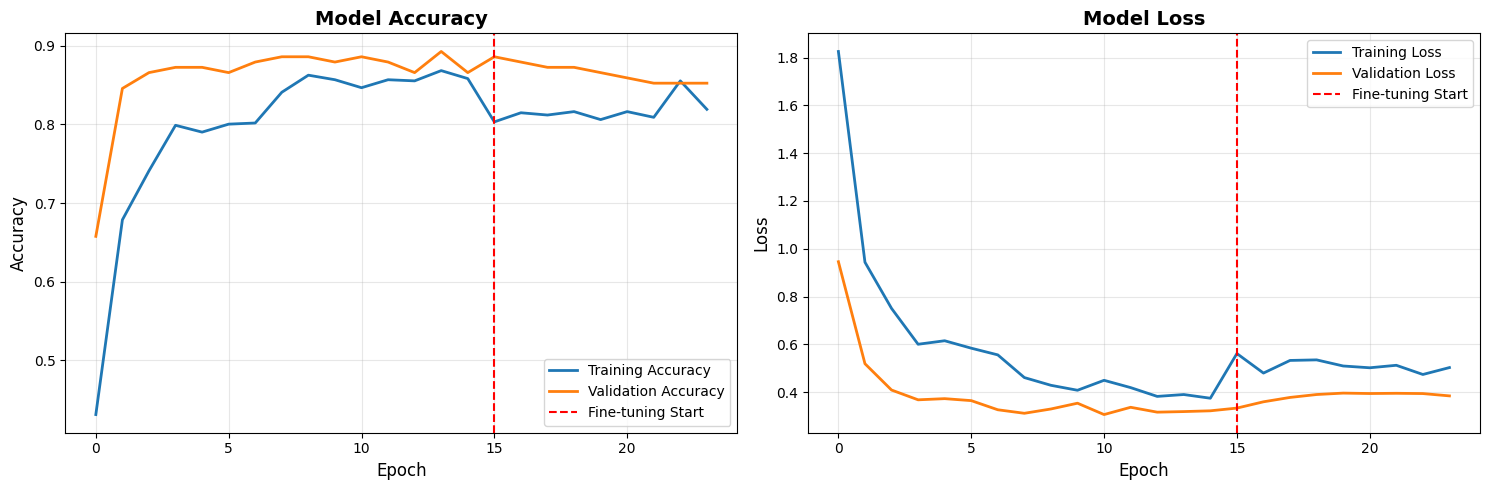

Training history saved!


In [ ]:
print("\n[6/7] Generating Training Visualizations...")

def plot_training_history(history1, history2):
    """Plot combined training history"""

    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(len(acc))
    phase1_end = len(history1.history['accuracy'])

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    axes[0].plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
    axes[0].plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
    axes[0].axvline(x=phase1_end, color='r', linestyle='--', label='Fine-tuning Start')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(epochs_range, loss, label='Training Loss', linewidth=2)
    axes[1].plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
    axes[1].axvline(x=phase1_end, color='r', linestyle='--', label='Fine-tuning Start')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=300)
    plt.show()

    print(f"Training history saved!")

plot_training_history(history_phase1, history_phase2)



[7/7] Evaluating Model on Test Set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - accuracy: 0.8516 - loss: 0.4155 - top_3_accuracy: 0.9766

TEST SET EVALUATION RESULTS
Test Loss:          0.4188
Test Accuracy:      0.8301 (83.01%)
Test Top-3 Accuracy: 0.9804 (98.04%)

Generating predictions for detailed analysis...
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step


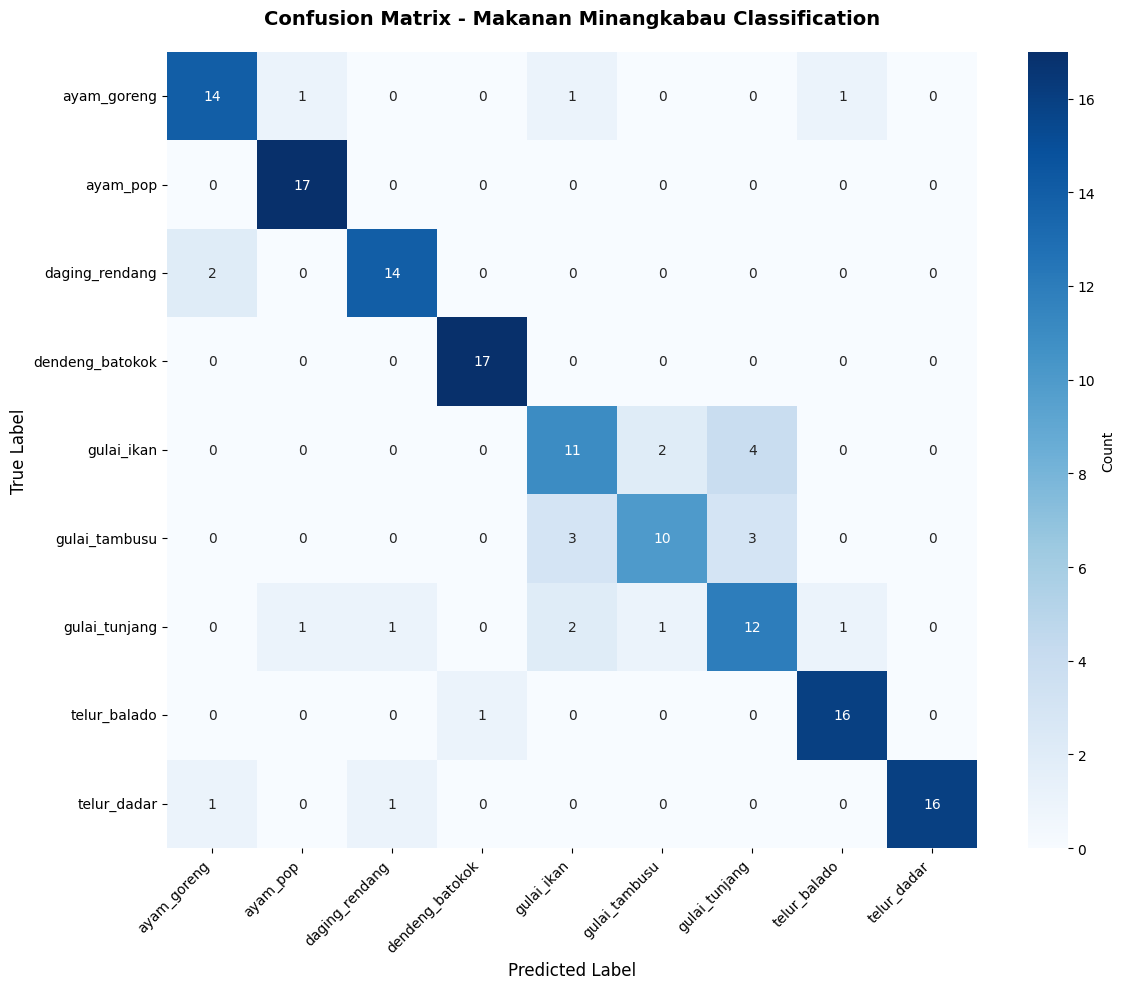

Confusion matrix saved!

Classification Report:
                 precision    recall  f1-score   support

    ayam_goreng     0.8235    0.8235    0.8235        17
       ayam_pop     0.8947    1.0000    0.9444        17
 daging_rendang     0.8750    0.8750    0.8750        16
dendeng_batokok     0.9444    1.0000    0.9714        17
     gulai_ikan     0.6471    0.6471    0.6471        17
  gulai_tambusu     0.7692    0.6250    0.6897        16
  gulai_tunjang     0.6316    0.6667    0.6486        18
   telur_balado     0.8889    0.9412    0.9143        17
    telur_dadar     1.0000    0.8889    0.9412        18

       accuracy                         0.8301       153
      macro avg     0.8305    0.8297    0.8284       153
   weighted avg     0.8304    0.8301    0.8285       153


Per-Class Accuracy:
ayam_goreng              : 0.8235 (14/17)
ayam_pop                 : 1.0000 (17/17)
daging_rendang           : 0.8750 (14/16)
dendeng_batokok          : 1.0000 (17/17)
gulai_ikan         

In [ ]:
print("\n[7/7] Evaluating Model on Test Set...")

# Evaluate
test_loss, test_accuracy, test_top3_accuracy = model.evaluate(
    test_generator,
    verbose=1
)

print("\n" + "="*60)
print("TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Test Loss:          {test_loss:.4f}")
print(f"Test Accuracy:      {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Top-3 Accuracy: {test_top3_accuracy:.4f} ({test_top3_accuracy*100:.2f}%)")
print("="*60)

# Predictions for confusion matrix
print("\nGenerating predictions for detailed analysis...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Makanan Minangkabau Classification',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")

# Classification Report
print("\nClassification Report:")
print("="*60)
report = classification_report(true_classes, predicted_classes,
                               target_names=class_names,
                               digits=4)
print(report)

# Save report
with open(os.path.join(OUTPUT_DIR, 'classification_report.txt'), 'w') as f:
    f.write("Classification Report - Makanan Minangkabau\n")
    f.write("="*60 + "\n")
    f.write(report)
    f.write("\n" + "="*60 + "\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test Top-3 Accuracy: {test_top3_accuracy:.4f}\n")

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = np.sum((true_classes == i) & (predicted_classes == i))
    class_total = np.sum(true_classes == i)
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:25s}: {class_accuracy:.4f} ({class_correct}/{class_total})")


Generating sample predictions visualization...


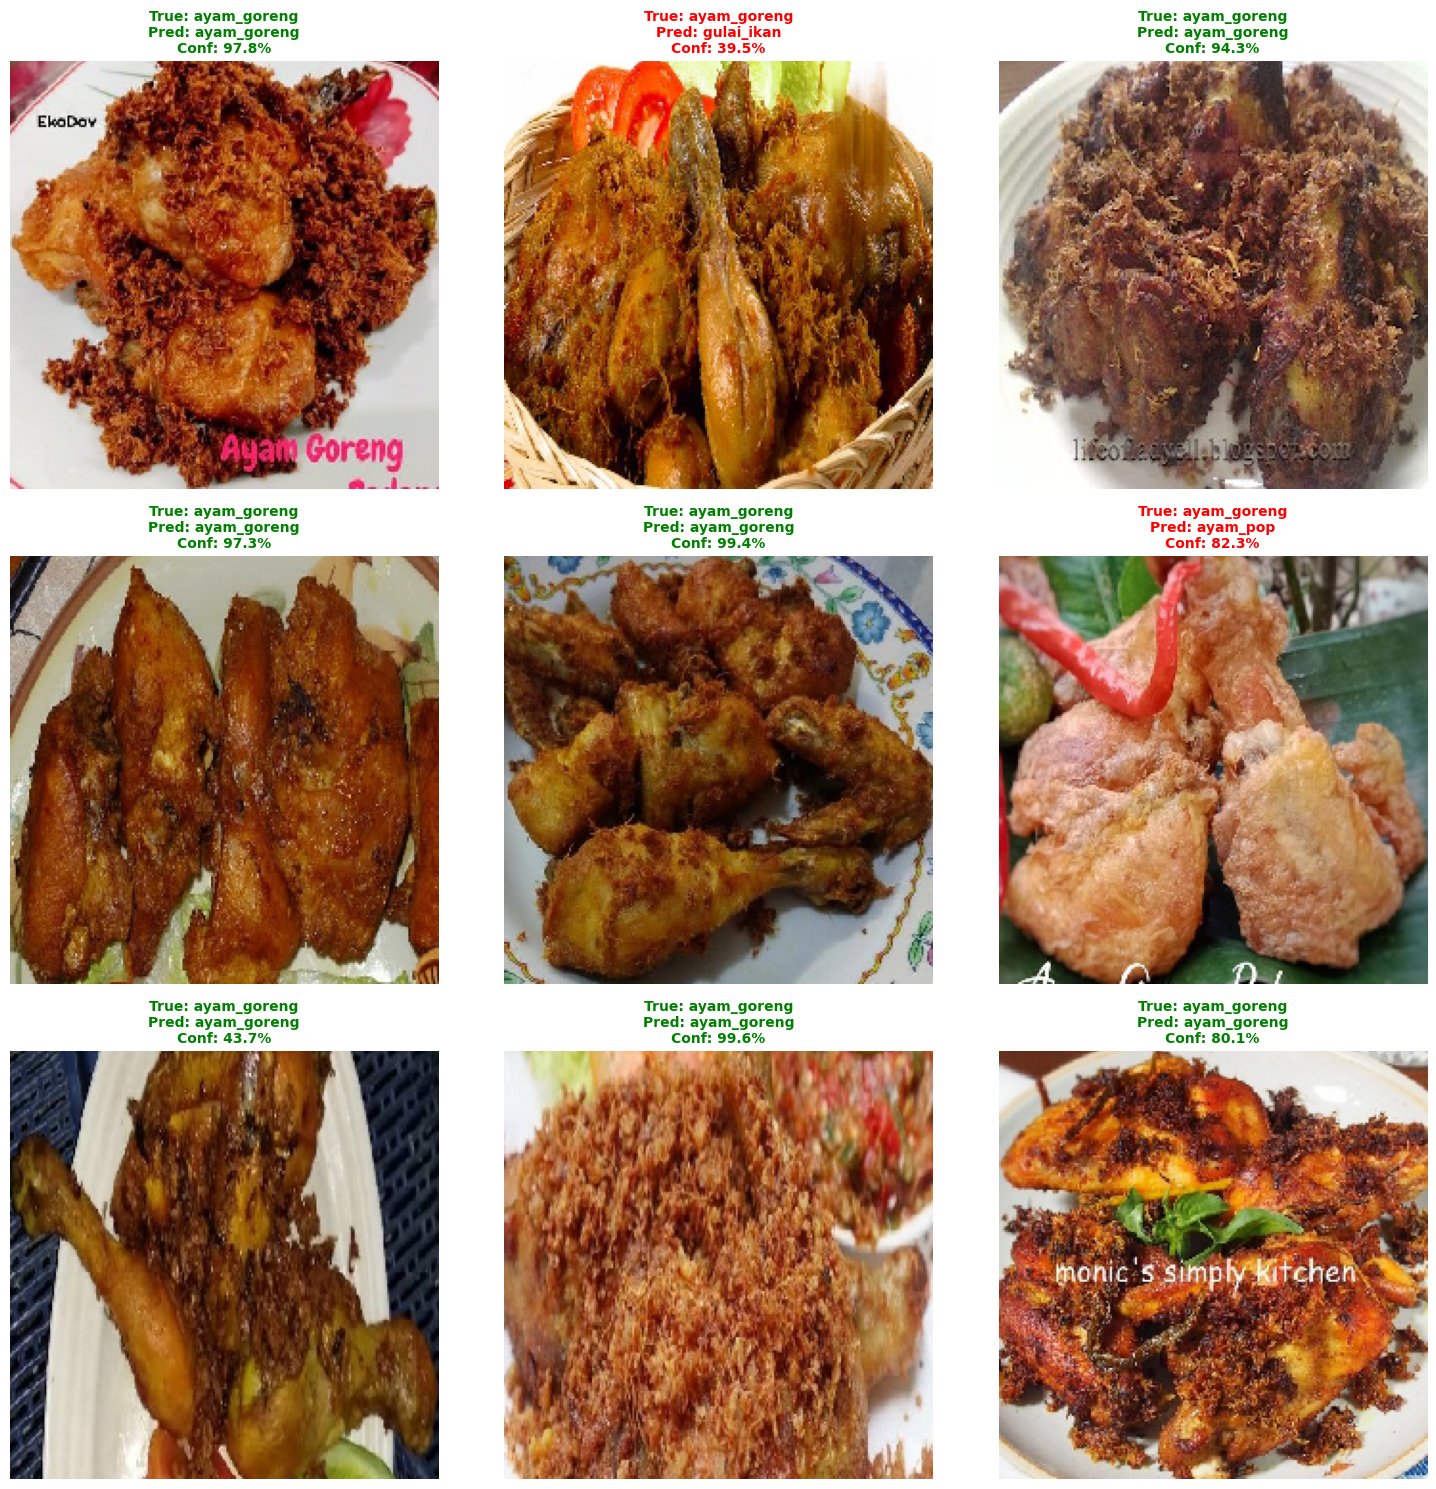

In [ ]:
def visualize_predictions(model, generator, num_images=9):
    """Visualize predictions on sample images"""

    generator.reset()
    images, labels = next(generator)
    predictions = model.predict(images, verbose=0)

    num_images = min(num_images, len(images))
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()

    for i in range(num_images):
        axes[i].imshow(images[i])

        true_idx = np.argmax(labels[i])
        pred_idx = np.argmax(predictions[i])
        confidence = predictions[i][pred_idx] * 100

        true_label = class_names[true_idx]
        pred_label = class_names[pred_idx]

        color = 'green' if true_idx == pred_idx else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                         color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')

    # Hide extra subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
    plt.show()

print("\nGenerating sample predictions visualization...")
visualize_predictions(model, test_generator, num_images=9)

In [ ]:
print("\n" + "="*60)
print("CONVERTING MODEL FOR FLUTTER DEPLOYMENT")
print("="*60)

# 1. Convert to TFLite (Standard)
print("\n1. Converting to TensorFlow Lite (Standard)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_path = os.path.join(OUTPUT_DIR, 'mobilenetv3_small_minangkabau.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

tflite_size = os.path.getsize(tflite_path) / 1024 / 1024
print(f"✓ Standard TFLite model saved: {tflite_path}")
print(f"  Size: {tflite_size:.2f} MB")

# 2. Convert to TFLite (Quantized - Recommended for Mobile)
print("\n2. Converting to TensorFlow Lite (Quantized - Recommended)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset for quantization
def representative_dataset():
    train_generator.reset()
    for _ in range(min(100, len(train_generator))):
        images, _ = next(train_generator)
        for image in images:
            yield [np.expand_dims(image, axis=0).astype(np.float32)]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quantized_model = converter.convert()

tflite_quantized_path = os.path.join(OUTPUT_DIR, 'mobilenetv3_small_minangkabau_quantized.tflite')
with open(tflite_quantized_path, 'wb') as f:
    f.write(tflite_quantized_model)

tflite_quantized_size = os.path.getsize(tflite_quantized_path) / 1024 / 1024
print(f"✓ Quantized TFLite model saved: {tflite_quantized_path}")
print(f"  Size: {tflite_quantized_size:.2f} MB")
print(f"  Compression: {((tflite_size - tflite_quantized_size) / tflite_size * 100):.1f}%")

# 3. Test TFLite model
print("\n3. Testing TFLite Model...")
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test on one image
test_generator.reset()
test_images, test_labels = next(test_generator)
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
tflite_predictions = interpreter.get_tensor(output_details[0]['index'])

print(f"✓ TFLite model test successful!")
print(f"  Input shape: {input_details[0]['shape']}")
print(f"  Output shape: {output_details[0]['shape']}")


CONVERTING MODEL FOR FLUTTER DEPLOYMENT

1. Converting to TensorFlow Lite (Standard)...
Saved artifact at '/tmp/tmpqksrcqmq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  138749209593808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209596880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209597456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209594000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209596304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209593040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209598032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209595920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138749209596688: TensorSpec(shape=(), dtype=tf.resource, name=None

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✓ Quantized TFLite model saved: output_mobilenetv3_small_20251103_111044/mobilenetv3_small_minangkabau_quantized.tflite
  Size: 1.31 MB
  Compression: 68.3%

3. Testing TFLite Model...
✓ TFLite model test successful!
  Input shape: [  1 224 224   3]
  Output shape: [1 9]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
